# CNN for FCAL Shower Classification

## Prepare Dataset

In [1]:
%pip install h5py torch torchvision tqdm safetensors > /dev/null

In [2]:
import os
from urllib.parse import urlparse
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Custom TQDM progress bar for urllib downloads."""
    def update_to(self, blocks=1, block_size=1, total_size=None):
        """
        Update the progress bar.

        Args:
            blocks (int): Number of blocks transferred so far.
            block_size (int): Size of each block (in bytes).
            total_size (int, optional): Total size of the file (in bytes).
        """
        if total_size is not None:
            self.total = total_size
        self.update(blocks * block_size - self.n)


def download(url, target_dir):
    """
    Download a file from a URL into the target directory with progress display.

    Args:
        url (str): Direct URL to the file.
        target_dir (str): Directory to save the file.

    Returns:
        str: Path to the downloaded (or existing) file.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Infer the filename from the URL
    filename = os.path.basename(urlparse(url).path)
    local_path = os.path.join(target_dir, filename)

    # If file already exists, skip download
    if os.path.exists(local_path):
        print(f"✅ File already exists: {local_path}")
        return local_path

    # Download with progress bar
    print(f"⬇️  Downloading {filename} from {url}")

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
        urllib.request.urlretrieve(url, filename=local_path, reporthook=t.update_to)

    print(f"✅ Download complete: {local_path}")
    return local_path

In [8]:

dataset_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_GUN_PATCHSIZE_11.h5"
data_dir = "data"
dataset_path = download(dataset_url, data_dir)



⬇️  Downloading CNN4FCAL_GUN_PATCHSIZE_11.h5 from https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_GUN_PATCHSIZE_11.h5


CNN4FCAL_GUN_PATCHSIZE_11.h5: 30.3MB [00:00, 37.1MB/s]                            

✅ Download complete: data/CNN4FCAL_GUN_PATCHSIZE_11.h5


### Step 1: Open and Inspect the `.h5` File

We can open the dataset and confirm whats inside it


In [9]:
import h5py, numpy as np
with h5py.File(dataset_path, "r") as f:
    print("✅ Datasets available:", list(f.keys()))
    print("🔍 patches shape:", f["patches"].shape)
    print("🔍 labels shape:", f["label"].shape)

✅ Datasets available: ['label', 'patches', 'showerE', 'thrownE']
🔍 patches shape: (814151, 11, 11)
🔍 labels shape: (814151,)


### Step 2: Create a Custom PyTorch Dataset

This dataset will:

* Read directly from the `.h5` file
* Load entries on demand (not all into memory)
* Optionally we can apply normalization in the form of transformation

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np # Import numpy

class FCALPatchDataset(Dataset):
    def __init__(self, h5_path, indices=None, transform=None):
        """
        Parameters
        ----------
        h5_path : str
            Path to the HDF5 file.
        indices : list or np.ndarray, optional
            Subset of indices to use (for train/val/test split).
        transform : callable, optional
            Optional transform to apply to each patch.
        """
        # Open the file handle here and keep it open
        self.h5_path = h5_path
        self.file = h5py.File(self.h5_path, "r")
        self.indices = indices
        self.transform = transform

        # Assign datasets directly from the file handle
        self.length = len(self.file["label"])
        self.patches = np.array(self.file["patches"], dtype=np.float32)
        self.patches = self.patches[self.indices] if self.indices is not None else self.patches
        self.labels = np.array(self.file["label"], dtype=np.int64)
        self.labels = self.labels[self.indices if self.indices is not None else slice(None)]
        self.showerE = np.array(self.file["showerE"], dtype=np.float32)
        self.showerE = self.showerE[self.indices if self.indices is not None else slice(None)]
        self.thrownE = np.array(self.file["thrownE"], dtype=np.float32)
        self.thrownE = self.thrownE[self.indices if self.indices is not None else slice(None)]
        self.file.close()

    def __len__(self):
        return len(self.indices) if self.indices is not None else self.length

    def __getitem__(self, idx):
        # Handle subset indices

        # Access data directly from the assigned attributes
        patch = self.patches[idx]
        label = self.labels[idx]
        showerE = self.showerE[idx]
        thrownE = self.thrownE[idx]

        # Optional transform
        if self.transform:
            patch = self.transform(patch)

        # Convert to torch tensors
        patch = torch.from_numpy(patch).unsqueeze(0)  # (1, 11, 11)
        return patch, label, showerE, thrownE

### Step 3: Split into Train / Validation / Testing


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# Read total number of samples
with h5py.File(dataset_path, "r") as f:
    N = len(f["label"])
    labels = np.array(f["label"])  # ✅ Read dataset into memory

indices = np.arange(N)
n_photons = np.sum(labels == 1)
n_splitOffs = np.sum(labels == 0)

counts = np.array([n_splitOffs, n_photons], dtype = np.float32)

# 70% train, 15% val, 15% test (stratified by class labels)
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, stratify=labels, random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=42
)


### Step 4: Create Dataset and DataLoader Objects

Let us normalize each of the images with the total energy of all the hits in the shower

In [12]:


ENERGY_SCALE  = 0.05    # GeV (for global log scaling)
CLIP_MAX      = 2.0     # GeV per cell clamp for scaling
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA
BATCH_SIZE    = 512
NUM_WORKERS = 1
pin = (DEVICE == "cuda")

def log_global_norm(W, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Keep everything float32 to avoid silent upcasts to float64
    W    = W.clip(min=0).astype(np.float32, copy=False)
    e0   = np.float32(e0)
    emax = np.float32(emax)
    Z = np.log1p(W / e0).astype(np.float32, copy=False)
    Z /= np.log1p(emax / e0).astype(np.float32, copy=False)
    np.clip(Z, 0.0, 1.0, out=Z)
    return Z  # float32

def normalize_patch(patch):
    # Example normalization to total energy = 1
    total = np.sum(patch)
    return patch / total if total > 0 else patch

train_ds = FCALPatchDataset(dataset_path, indices=train_idx, transform=log_global_norm)
val_ds   = FCALPatchDataset(dataset_path, indices=val_idx, transform=log_global_norm)
test_ds  = FCALPatchDataset(dataset_path, indices=test_idx, transform=log_global_norm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True
                          )
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False
                          )
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False
                          )


In [41]:
# lets check a few samples

patches, labels, showerE, thrownE = next(iter(train_loader))
print("Batch shape:", patches.shape)    # (B, 1, 11, 11)
print("Labels:", labels[:8])
print("showerE:", showerE[:8])
print("thrownE:", thrownE[:8])

Batch shape: torch.Size([512, 1, 11, 11])
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 1])
showerE: tensor([0.1467, 1.1496, 0.9625, 0.3645, 1.5525, 1.4257, 1.0802, 1.8474])
thrownE: tensor([1.6663, 1.1155, 1.1404, 0.9574, 1.5913, 1.4105, 1.1804, 1.8689])


## CNN Model Architecture and training

The architerure will have the following architecture

| Layer Type                        | Output Channels | Kernel / Operation | Purpose                                                             |
| --------------------------------- | --------------- | ------------------ | ------------------------------------------------------------------- |
| `Conv2d` + `BatchNorm2d` + `ReLU` | 16              | 3×3                | Extract local energy patterns and normalize activations.            |
| `MaxPool2d(2)`                    | —               | 2×2 downsample     | Reduce spatial resolution and emphasize dominant features.          |
| `Conv2d` + `BatchNorm2d` + `ReLU` | 32              | 3×3                | Capture higher-level correlations (e.g., multi-peak structure).     |
| `MaxPool2d(2)`                    | —               | —                  | Further compress spatial information.                               |
| `Conv2d` + `BatchNorm2d` + `ReLU` | 64              | 3×3                | Learn more abstract, class-discriminating representations.          |
| `AdaptiveAvgPool2d(1)`            | —               | Global average     | Collapse the spatial dimension to a single latent vector (size 64). |
| `Linear(64 → 2)`                  | —               | Fully connected    | Classify into photon (1) or split-off (0).                          |


In [15]:
import torch, torch.nn as nn

# ---------------------------
# Model
# ---------------------------
class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Linear(64, n_classes)
    def forward(self, x):
        return self.head(self.net(x).flatten(1))

In [22]:

from torch.nn.functional import one_hot as one_hot
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score, confusion_matrix
from contextlib import nullcontext
import math
from safetensors.torch import save_model

# ---------------------------
# Eval & Train (with progress bars + new AMP)
# ---------------------------
EPOCHS = 20
LR = 3e-4

@torch.inference_mode()
def evaluate(model, loader, desc="Eval", returnShowerE = False, returnthrownE = False):
    model.eval()
    ys, ps = [], []
    correct = total = 0
    bar = tqdm(loader, desc=desc, leave=False)
    shE = []
    thE = []
    for Xb, yb, showerE, thrownE in bar:
        Xb = Xb.to(DEVICE, non_blocking=True, dtype=torch.float32)
        yb = yb.to(DEVICE, non_blocking=True)
        logits = model(Xb)
        prob = torch.softmax(logits, dim=1)[:, 1]
        pred = logits.argmax(dim=1)
        ys.append(yb.cpu().numpy()); ps.append(prob.cpu().numpy())
        shE.append(showerE.cpu().numpy())
        thE.append(thrownE.cpu().numpy())
        correct += (pred == yb).sum().item(); total += yb.numel()
        bar.set_postfix(acc=f"{(correct/max(1,total)):.3f}")
    y_true = np.concatenate(ys) if ys else np.array([])
    y_prob = np.concatenate(ps) if ps else np.array([])
    showerE = np.concatenate(shE) if shE else np.array([])
    thrownE = np.concatenate(thE) if thE else np.array([])
    acc = correct / max(1, total)
    auc = roc_auc_score(y_true, y_prob) if y_true.size and np.unique(y_true).size > 1 else float("nan")
    if returnShowerE:
      return acc, auc, y_true, y_prob, showerE
    elif returnthrownE:
      return acc, auc, y_true, y_prob, thrownE
    else:
      return acc, auc, y_true, y_prob

def train(model, opt, train_loader, val_loader, save_path = "./models", counts = counts, epochs = EPOCHS):

    os.makedirs(save_path, exist_ok=True)
    weights = torch.tensor((counts.sum() / (counts + 1e-6)), dtype=torch.float32, device=DEVICE)
    crit  = nn.CrossEntropyLoss(weight=weights)
    scaler = torch.amp.GradScaler('cuda') if USE_AMP else None

    best_auc, best_state, patience, bad = -1.0, None, 5, 0
    for epoch in trange(1, epochs+1, desc="Training"):
        model.train()
        running, seen, correct = 0.0, 0, 0
        bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} (train)", leave=False)

        for Xb, yb, _, _ in bar:
            Xb = Xb.to(DEVICE, non_blocking=True, dtype=torch.float32)
            yb = yb.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            ctx = torch.amp.autocast(device_type='cuda', dtype=torch.float16) if USE_AMP else nullcontext()
            with ctx:
                logits = model(Xb)
                loss = crit(logits, yb)
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            running += loss.item() * yb.size(0)
            seen    += yb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            bar.set_postfix(avg_loss=f"{running/max(1,seen):.4f}", acc=f"{(correct/max(1,seen)):.3f}")

        train_loss = running / max(1, seen)
        val_acc, val_auc, _, _ = evaluate(model, val_loader, desc=f"Epoch {epoch}/{EPOCHS} (val)")
        tqdm.write(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_auc {val_auc:.4f}")

        score = 0.0 if math.isnan(val_auc) else val_auc
        if score > best_auc:
            best_auc, bad = score, 0
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            tqdm.write(f"✓ New best AUC {best_auc:.4f}")
            save_model(model, os.path.join(save_path, "FCALClassifier.safetensors"))
        else:
            bad += 1
            if bad >= patience:
                tqdm.write("Early stopping.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)

    return model


In [44]:
model = SmallCNN().to(DEVICE).to(torch.float32)
opt   = torch.optim.AdamW(model.parameters(), lr=LR)
save_path = "/home/ksuresh/data10/DNP2025/models"

In [45]:
model = train(model, opt, train_loader, val_loader, save_path)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 1/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 01 | train_loss 0.2729 | val_acc 0.8956 | val_auc 0.9575
✓ New best AUC 0.9575


Epoch 2/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 2/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 02 | train_loss 0.2575 | val_acc 0.8982 | val_auc 0.9583
✓ New best AUC 0.9583


Epoch 3/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 3/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 03 | train_loss 0.2543 | val_acc 0.9001 | val_auc 0.9595
✓ New best AUC 0.9595


Epoch 4/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 4/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 04 | train_loss 0.2524 | val_acc 0.9003 | val_auc 0.9599
✓ New best AUC 0.9599


Epoch 5/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 5/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 05 | train_loss 0.2510 | val_acc 0.8987 | val_auc 0.9598


Epoch 6/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 6/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 06 | train_loss 0.2502 | val_acc 0.9014 | val_auc 0.9605
✓ New best AUC 0.9605


Epoch 7/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 7/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 07 | train_loss 0.2490 | val_acc 0.9011 | val_auc 0.9606
✓ New best AUC 0.9606


Epoch 8/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 8/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 08 | train_loss 0.2486 | val_acc 0.8986 | val_auc 0.9602


Epoch 9/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 9/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 09 | train_loss 0.2479 | val_acc 0.9022 | val_auc 0.9609
✓ New best AUC 0.9609


Epoch 10/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 10/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 10 | train_loss 0.2471 | val_acc 0.9019 | val_auc 0.9608


Epoch 11/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 11/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 11 | train_loss 0.2464 | val_acc 0.9006 | val_auc 0.9612
✓ New best AUC 0.9612


Epoch 12/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 12/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 12 | train_loss 0.2461 | val_acc 0.9021 | val_auc 0.9616
✓ New best AUC 0.9616


Epoch 13/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 13/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 13 | train_loss 0.2455 | val_acc 0.9018 | val_auc 0.9615


Epoch 14/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 14/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 14 | train_loss 0.2452 | val_acc 0.9015 | val_auc 0.9615


Epoch 15/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 15/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 15 | train_loss 0.2449 | val_acc 0.9004 | val_auc 0.9614


Epoch 16/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 16/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 16 | train_loss 0.2444 | val_acc 0.9018 | val_auc 0.9619
✓ New best AUC 0.9619


Epoch 17/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 17/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 17 | train_loss 0.2442 | val_acc 0.9018 | val_auc 0.9616


Epoch 18/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 18/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 18 | train_loss 0.2435 | val_acc 0.9028 | val_auc 0.9618


Epoch 19/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 19/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 19 | train_loss 0.2432 | val_acc 0.9020 | val_auc 0.9617


Epoch 20/20 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 20/20 (val):   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 20 | train_loss 0.2429 | val_acc 0.8991 | val_auc 0.9608


## Model Testing


### Test scores

In [24]:
model = SmallCNN().to(DEVICE).to(torch.float32)
save_path = "./models"
model_url = "https://huggingface.co/AI4EIC/DNP2025-tutorial/resolve/main/FCALClassifier.safetensors"
model_path = download(model_url, save_path)
from safetensors import safe_open

tensors = {}
with safe_open(model_path, framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)
model.load_state_dict(tensors)

⬇️  Downloading FCALClassifier.safetensors from https://huggingface.co/AI4EIC/DNP2025-tutorial/resolve/main/FCALClassifier.safetensors


FCALClassifier.safetensors: 98.3kB [00:00, 238kB/s]                             

✅ Download complete: ./models/FCALClassifier.safetensors


<All keys matched successfully>

Test:   0%|          | 0/239 [00:00<?, ?it/s]

Test | acc 0.9028 | auc 0.9626


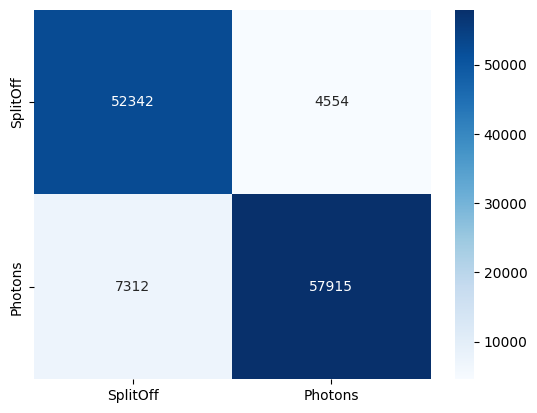

In [23]:
test_acc, test_auc, y_true, y_prob = evaluate(model, test_loader, desc="Test")
cm = confusion_matrix(y_true, (y_prob >= 0.5).astype(int), labels=[0, 1])
print(f"Test | acc {test_acc:.4f} | auc {test_auc:.4f}")
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["SplitOff","Photons"], yticklabels=["SplitOff","Photons"])
plt.show()

In [48]:
# Reference values from https://arxiv.org/pdf/2002.09530
# 85% signal with 60% background rejection


import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

# y_true: 0 = photon (signal), 1 = split-off (background)
# y_prob: model score = P(split-off)

def eff_rej_at_threshold(y_true, y_prob, thr):
    y_true = np.asarray(y_true, dtype=int)
    y_prob = np.asarray(y_prob, dtype=float)

    keep_photon = (y_prob < thr)
    Nsig = np.sum(y_true == 0); Nbkg = np.sum(y_true == 1)

    eps_sig = np.sum((y_true == 0) & keep_photon) / max(1, Nsig)
    rej_bkg = np.sum((y_true == 1) & (~keep_photon)) / max(1, Nbkg)  # predicted split-off

    # Predicted label: 1=split-off, 0=photon (consistent with y_true)
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return eps_sig, rej_bkg, cm

def eff_rej_curve(y_true, y_prob):
    # Standard ROC for positive class = split-off (1)
    fpr, tpr, thrs = roc_curve(y_true, y_prob, pos_label=1)
    # Map to your physics metrics:
    eps_sig = 1.0 - fpr   # photon efficiency
    rej_bkg = tpr         # split-off rejection
    return eps_sig, rej_bkg, thrs

# --- Example usage ---
# If you have them already from evaluate():
# y_true, y_prob = <from your test set>

# 1) Curve over all thresholds
eps_sig, rej_bkg, thrs = eff_rej_curve(y_true, y_prob)

# 2) Pick a working point: match Barsotti–Shepherd ε_sig ≈ 0.85
target_eps = 0.85
i = int(np.argmin(np.abs(eps_sig - target_eps)))
thr_star = thrs[i]
eps_star, rej_star, cm_star = eff_rej_at_threshold(y_true, y_prob, thr_star)

print(f"Working point (ε_sig≈{target_eps:.2f}):")
print(f"  threshold = {thr_star:.4f}")
print(f"  ε_sig (photon eff)   = {eps_star:.4f}")
print(f"  R_bkg (split-off rej)= {rej_star:.4f}")
print("  Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):")
print(cm_star)

# 3) If you just want your current threshold, e.g. t=0.5:
eps_05, rej_05, cm_05 = eff_rej_at_threshold(y_true, y_prob, 0.5)
print(f"\nAt t=0.50: ε_sig={eps_05:.4f}, R_bkg={rej_05:.4f}")


Working point (ε_sig≈0.85):
  threshold = 0.2809
  ε_sig (photon eff)   = 0.8500
  R_bkg (split-off rej)= 0.9380
  Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):
[[48362  8534]
 [ 4044 61183]]

At t=0.50: ε_sig=0.9200, R_bkg=0.8879


### Figure of Merit (FoM) Definitions

In binary classifier optimization specifically one dealing with signal and backgrounds, the **optimal threshold** is chosen by maximizing a *Figure of Merit (FoM)* that quantifies the balance between signal efficiency and background suppression.

---

#### **Signal Significance**

A commond way of defining **signal significance** is as follows,

$$
\text{FoM}_{\text{sig}} = \frac{S}{\sqrt{S + B}}
$$

where:
- $ S = N_S \, \varepsilon_S $ is the number of selected signal events,
- $ B = N_B \, \varepsilon_B $ is the number of selected background events,
- $ \varepsilon_S $ is the **signal efficiency** (fraction of true signal retained),
- $ \varepsilon_B $ is the **background efficiency** (fraction of background misclassified as signal).

This FoM estimates the expected **statistical significance** of signal observation in the presence of background.

---

#### **Purity**

Purity measures how “clean” the selected sample is, i.e., the fraction of signal among all selected events:

$
\text{Purity} = \frac{S}{S + B}
$

Substituting in terms of efficiencies and total counts:

$
\text{Purity} = \frac{N_S \, \varepsilon_S}{N_S \, \varepsilon_S + N_B \, \varepsilon_B}
$

If the dataset’s signal-to-background ratio \( N_S / N_B \) is known, this becomes:

$
\text{Purity} = \frac{\varepsilon_S}{\varepsilon_S + \varepsilon_B / (N_S / N_B)}
$

---

#### **Interpretation**

- **Signal Significance** → best when you want to *maximize discovery potential* (e.g., physics searches).  
- **Purity** → best when you want *clean signal selection* (e.g., building templates or performing precise fits).


In [57]:
def find_optimal_threshold(y_true, y_prob, S_over_B=1.0):
    """
    optimization using FoM maximization.
    y_true: 0 = photon (signal), 1 = split-off (background)
    y_prob: model score (probability of split-off)
    S_over_B: expected signal-to-background ratio (S/B) in dataset
    """
    fpr, tpr, thrs = roc_curve(y_true, y_prob, pos_label=1)
    eps_sig = 1 - fpr
    eps_bkg = 1 - tpr  # background efficiency, not rejection

    # Signal significance (TMVA default FoM)
    # S/√(S+B)
    fom = eps_sig / np.sqrt(eps_sig + eps_bkg / S_over_B + 1e-12)
    purity = eps_sig / (eps_sig + eps_bkg / S_over_B + 1e-12)
    i_opt = np.argmax(fom)
    thr_opt = thrs[i_opt]

    return {
        "threshold": float(thr_opt),
        "eps_sig": float(eps_sig[i_opt]),
        "rej_bkg": float(1 - eps_bkg[i_opt]),
        "SoverSqrtSB": float(fom[i_opt]),
        "purity": purity[i_opt],
        "curve": {"thresholds": thrs, "eps_sig": eps_sig, "rej_bkg": 1 - eps_bkg, "FoM": fom, "purity": purity},
    }

# --- Example ---
opt = find_optimal_threshold(y_true, y_prob, S_over_B=1.0)
print(f"Optimal point Summary:")
print(f"  threshold = {opt['threshold']:.3f}")
print(f"  ε_sig      = {opt['eps_sig']:.3f}")
print(f"  R_bkg      = {opt['rej_bkg']:.3f}")
print(f"  FoM (S/sqrt(S+B)) = {opt['SoverSqrtSB']:.3f}")
print(f"  Purity     = {opt['purity']:.3f}")


Optimal point Summary:
  threshold = 0.525
  ε_sig      = 0.918
  R_bkg      = 0.857
  FoM (S/sqrt(S+B)) = 0.891
  Purity     = 0.865


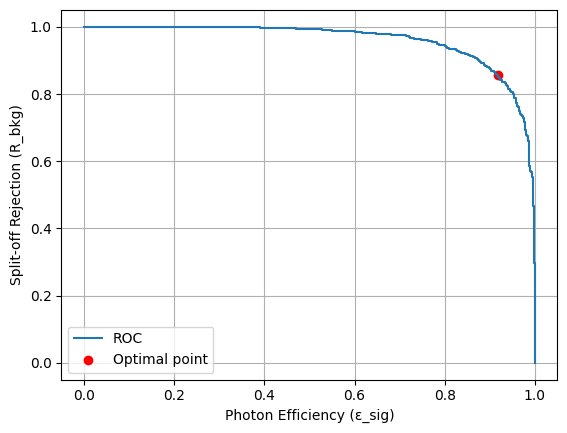

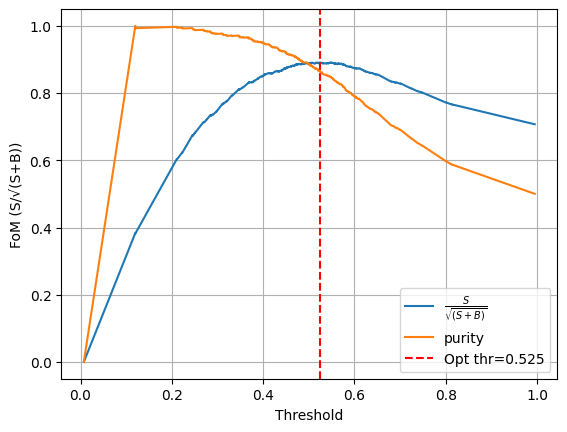

In [85]:
import matplotlib.pyplot as plt

plt.plot(opt["curve"]["eps_sig"], opt["curve"]["rej_bkg"], label="ROC")
plt.scatter(opt["eps_sig"], opt["rej_bkg"], color="r", label="Optimal point")
plt.xlabel("Photon Efficiency (ε_sig)")
plt.ylabel("Split-off Rejection (R_bkg)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(opt["curve"]["thresholds"], opt["curve"]["FoM"], label = r"$\frac{S}{\sqrt{(S+B)}}$")
plt.plot(opt["curve"]["thresholds"], opt["curve"]["purity"], label = "purity")
plt.axvline(opt["threshold"], color="r", ls="--", label=f"Opt thr={opt['threshold']:.3f}")
plt.xlabel("Threshold")
plt.ylabel("FoM (S/√(S+B))")
plt.legend()
plt.grid(True)
plt.show()


### Performance in bins of showerE

In [61]:
EBins = [0.100, 0.500, 1.0, 2.0, 4.0]


test_acc, test_auc, y_true, y_prob, showerE = evaluate(model, test_loader, desc="Test", returnShowerE = True)


Test:   0%|          | 0/239 [00:00<?, ?it/s]

In [62]:
from sklearn.metrics import roc_auc_score, accuracy_score

def metrics_vs_energy(y_true, y_prob, showerE, EBins):
    """
    Compute accuracy and AUC vs shower energy bins.
    """
    EBins = np.asarray(EBins)
    labels = [f"[{EBins[i]:.1f}, {EBins[i+1]:.1f})" for i in range(len(EBins)-1)]
    results = []

    for i in range(len(EBins)-1):
        mask = (showerE >= EBins[i]) & (showerE < EBins[i+1])
        if not np.any(mask):
            results.append((labels[i], np.nan, np.nan, np.sum(mask)))
            continue
        yt = y_true[mask]
        yp = y_prob[mask]
        acc = accuracy_score(yt, yp >= 0.5)
        auc = roc_auc_score(yt, yp) if np.unique(yt).size > 1 else np.nan
        results.append((labels[i], acc, auc, np.sum(mask)))

    return results


In [64]:
acc, auc, y_true, y_prob, showerE = evaluate(model, test_loader, returnShowerE=True)
EBins = [0.100, 0.500, 1.0, 2.0, 4.0]

bin_results = metrics_vs_energy(y_true, y_prob, showerE, EBins)

print(f"{'E_bin':<15}{'Acc':>10}{'AUC':>10}{'Nevents':>10}")
for label, acc_b, auc_b, n in bin_results:
    print(f"{label:<15}{acc_b:10.3f}{auc_b:10.3f}{n:10d}")


Eval:   0%|          | 0/239 [00:00<?, ?it/s]

E_bin                 Acc       AUC   Nevents
[0.1, 0.5)          0.873     0.863     46603
[0.5, 1.0)          0.778     0.831     13455
[1.0, 2.0)          0.903     0.810     19009
[2.0, 4.0)          0.975     0.761     32519


[0.5 1.  1.5 2. ]


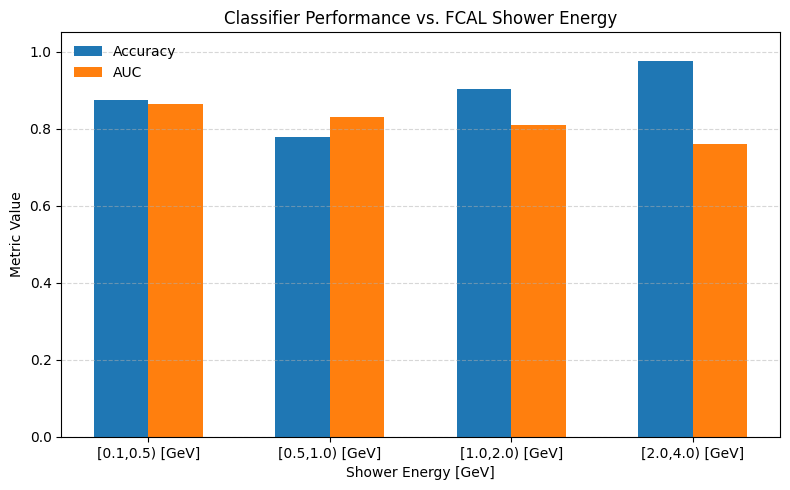

In [78]:
import numpy as np
import matplotlib.pyplot as plt

centers = 0.5 * (np.arange(1, len(EBins)))
print (centers)
width = 0.15  # bar width

accs = [r[1] for r in bin_results]
aucs = [r[2] for r in bin_results]

plt.figure(figsize=(8,5))

# Horizontal offsets for each metric
plt.bar(centers - 1.5*width, accs, width, label="Accuracy")
plt.bar(centers - 0.5*width, aucs, width, label="AUC")

# Styling
plt.xlabel("Shower Energy [GeV]")
plt.ylabel("Metric Value")
plt.title("Classifier Performance vs. FCAL Shower Energy")
plt.xticks(centers - 0.15, [f"[{EBins[i]:.1f},{EBins[i+1]:.1f}) [GeV]" for i in range(len(EBins)-1)])
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Inference on Physics events

In order to extract the performance of CNN photon identifier. Let us use Physics events. We will be comparing the performance of CNN w.r.t rectangular cut and no cuts.


| Mode                   | Shower selection                 | π⁰ combination rule | Weights           | ω reconstruction  |
| ---------------------- | -------------------------------- | ------------------- | ----------------- | ----------------- |
| **CNN-based**          | showers passing CNN photon score | all photon pairs    | 1/N (if multiple) | combine π⁰ + π⁺π⁻ |
| **Rectangular cut**    | showers within ±40 MeV of m(π⁰)  | all accepted        | 1/N               | combine π⁰ + π⁺π⁻ |
| **Benchmark (no cut)** | all showers                      | all possible        | none              | combine π⁰ + π⁺π⁻ |


Note: This is for pedagogical purposes only. A Physics based analysis would involve methods like Kinemattic Fitting which is beyond the scope of this tutorial


In [25]:
omega_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_OMEGA_PATCHSIZE_11.h5"

omega_path = download("https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_OMEGA_PATCHSIZE_11.h5", data_dir)

⬇️  Downloading CNN4FCAL_OMEGA_PATCHSIZE_11.h5 from https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_OMEGA_PATCHSIZE_11.h5


CNN4FCAL_OMEGA_PATCHSIZE_11.h5: 400MB [00:08, 46.8MB/s]                          

✅ Download complete: data/CNN4FCAL_OMEGA_PATCHSIZE_11.h5


In [27]:
import h5py

with h5py.File(omega_path, "r") as f:
    # Show top-level groups
    eventKeys = list(f.keys())
    print("Top-level keys:", eventKeys[:10])

    print(f"\nContents of {eventKeys[0]}:")
    for k, v in f[eventKeys[0]].items():
        print(f"  {k:20s} shape={v.shape} dtype={v.dtype}")


Top-level keys: ['event_000000', 'event_000001', 'event_000002', 'event_000003', 'event_000004', 'event_000005', 'event_000006', 'event_000007', 'event_000008', 'event_000009']

Contents of event_000000:
  piMinus_p4           shape=(4,) dtype=float64
  piPlus_p4            shape=(4,) dtype=float64
  shower_p4            shape=(2, 4) dtype=float32
  shower_patches       shape=(2, 11, 11) dtype=float32


In [67]:
import numpy as np
import torch

PI0_MASS = 0.1349768  # GeV
OMEGA_MASS = 0.78265  # GeV

def fourvec_mass(p4):
    """Compute invariant mass from p4 = [px, py, pz, E]."""
    px, py, pz, E = np.moveaxis(p4, -1, 0)
    m2 = E**2 - (px**2 + py**2 + pz**2)
    m2 = np.maximum(m2, 0.0)
    return np.sqrt(m2)

def combine_p4(p4a, p4b):
    """Combine two 4-vectors."""
    return p4a + p4b

def model_infer(model, patch, e0=ENERGY_SCALE, emax=CLIP_MAX):
    """Run CNN inference on one shower patch"""
    model.eval()
    patch_norm = log_global_norm(patch, e0=e0, emax=emax)
    X = torch.tensor(patch_norm[None, None, :, :], dtype=torch.float32, device=DEVICE)
    with torch.inference_mode():
        probs = torch.softmax(model(X), dim=1)
        pred_label = torch.argmax(probs).item()  # 0 or 1
    return pred_label  # photon probability


In [72]:
from itertools import combinations

def analyze_event(ev, model, rect_mass_window=0.04, label: int=1):
    """
    Run CNN, rectangular cut, and benchmark on one event.
    Returns a dict with reconstructed pi0 and omega masses and weights.
    """
    results = {"cnn": [], "rect": [], "bench": []}

    piPlus = ev["piPlus_p4"]
    piMinus = ev["piMinus_p4"]
    showers = ev["shower_p4"]
    patches = ev["shower_patches"]

    # --- CNN inference on each shower
    cnn_scores = [model_infer(model, patch) for patch in patches]
    good_cnn = [i for i, s in enumerate(cnn_scores) if s == label]  # threshold
    #print (f"Good CNN : {good_cnn}")
    # --- All combinations of showers for pi0
    pairs = list(combinations(range(len(showers)), 2))
    if not pairs:
        return results  # skip if < 2 showers

    # --- 1. CNN-based
    cnn_pairs = [p for p in pairs if p[0] in good_cnn and p[1] in good_cnn]
    #print (f"Total Pairs : {len(pairs)}, Length of cnn_paris {len(cnn_pairs)}")
    for pairs_sel, key in [(cnn_pairs, "cnn"), (pairs, "bench")]:
        if not pairs_sel: continue
        N = len(pairs_sel)
        for (i, j) in pairs_sel:
            p4_pi0 = combine_p4(showers[i], showers[j])
            m_pi0 = fourvec_mass(p4_pi0)
            p4_omega = combine_p4(p4_pi0, combine_p4(piPlus, piMinus))
            m_omega = fourvec_mass(p4_omega)
            results[key].append((m_pi0, m_omega, 1.0/N if key=="cnn" else 1.0))

    # --- 2. Rectangular cut
    rect_pairs = []
    for (i, j) in pairs:
        m_pi0 = fourvec_mass(combine_p4(showers[i], showers[j]))
        if abs(m_pi0 - PI0_MASS) < rect_mass_window:
            rect_pairs.append((i, j))
    Nrect = len(rect_pairs)
    for (i, j) in rect_pairs:
        p4_pi0 = combine_p4(showers[i], showers[j])
        m_pi0 = fourvec_mass(p4_pi0)
        p4_omega = combine_p4(p4_pi0, combine_p4(piPlus, piMinus))
        m_omega = fourvec_mass(p4_omega)
        results["rect"].append((m_pi0, m_omega, 1.0/Nrect if Nrect>0 else 1.0))

    return results


In [76]:
import h5py
from tqdm import tqdm

all_results = {"cnn": [], "rect": [], "bench": []}
PHOTON_LABEL = 1
PI0_MASS_CUT = 0.04 # fabs(pi0Mass - rec) <= 0.04 GeV
with h5py.File(omega_path, "r") as f:
    ev_keys = [k for k in f.keys() if k.startswith("event_")]
    for key in tqdm(ev_keys, desc="Running event inference"):
        ev = {k: np.array(v) for k, v in f[key].items()}
        out = analyze_event(ev, model, rect_mass_window=PI0_MASS_CUT, label=1)
        for mode in all_results:
            all_results[mode].extend(out[mode])


Running event inference: 100%|██████████| 97525/97525 [06:49<00:00, 237.96it/s]


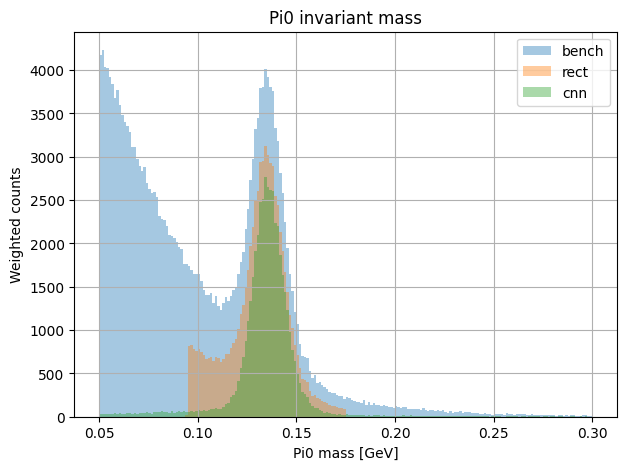

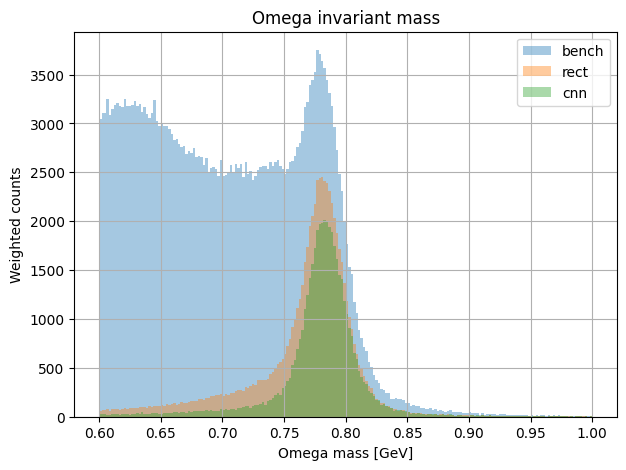

In [79]:
import matplotlib.pyplot as plt

def plot_mass_spectrum(all_results, key="omega", nbins=80, mass_range=(0,1.2), ylog = False):
    plt.figure(figsize=(7,5))
    for label, color in zip(["bench", "rect", "cnn"], ["gray", "blue", "orange"]):
        masses = [m[1 if key=="omega" else 0] for m in all_results[label]]
        weights = [m[2] for m in all_results[label]]
        plt.hist(masses, bins=nbins, range=mass_range, histtype="stepfilled",
                 alpha=0.4, label=label, weights=weights)
    plt.xlabel(f"{key.capitalize()} mass [GeV]")
    plt.ylabel("Weighted counts")
    plt.title(f"{key.capitalize()} invariant mass")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_mass_spectrum(all_results, key="pi0", nbins = 200, mass_range=(0.05,0.3))
plot_mass_spectrum(all_results, key="omega", nbins = 200, mass_range=(0.6,1.0))


/tmp/ipython-input-331058355.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  signal_yield = np.trapz(voigt_only(centers, A, m0, gamma, sigma), centers)


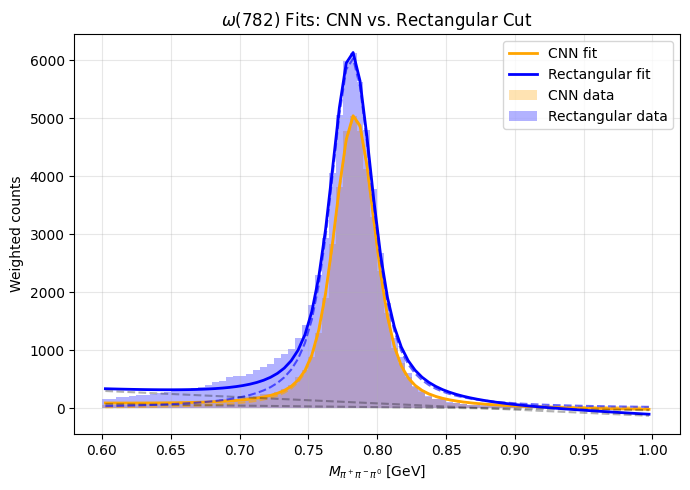

=== Fit Comparison ===

[Rectangular]
  m0     = 0.78137 GeV
  gamma  = 24.97 MeV (Lorentz width)
  sigma  = 8.79 MeV (Gaussian smear)
  Yield  = 299.6 (a.u.)

[CNN]
  m0     = 0.78358 GeV
  gamma  = 17.15 MeV (Lorentz width)
  sigma  = 10.61 MeV (Gaussian smear)
  Yield  = 223.9 (a.u.)


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# ------------------------
# Model definitions
# ------------------------
def voigt_plus_bkg(x, A, m0, gamma, sigma, b0, b1):
    """Voigtian (Lorentz ⊗ Gaussian) + linear background."""
    z = ((x - m0) + 1j * gamma / 2) / (sigma * np.sqrt(2))
    voigt = A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    return voigt + (b0 + b1 * x)

def voigt_only(x, A, m0, gamma, sigma):
    """Pure Voigtian signal component."""
    z = ((x - m0) + 1j * gamma / 2) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# ------------------------
# Fit utility
# ------------------------
def fit_mass_spectrum(masses, weights, label, color, range_omega=(0.6, 1.0), nbins=80):
    """Fit ω mass distribution with Voigt+linear background."""
    hist, bins = np.histogram(masses, bins=nbins, range=range_omega, weights=weights)
    centers = 0.5 * (bins[1:] + bins[:-1])

    # Initial guesses
    p0 = [max(hist), 0.782, 0.008, 0.02, np.min(hist), 0.0]
    popt, pcov = curve_fit(voigt_plus_bkg, centers, hist, p0=p0, maxfev=10000)
    A, m0, gamma, sigma, b0, b1 = popt

    # Compute signal yield (area under Voigt)
    signal_yield = np.trapz(voigt_only(centers, A, m0, gamma, sigma), centers)

    # Plot
    plt.plot(centers, voigt_plus_bkg(centers, *popt), color=color, lw=2, label=f"{label} fit")
    plt.plot(centers, voigt_only(centers, A, m0, gamma, sigma), "--", color=color, alpha=0.6)
    plt.plot(centers, b0 + b1*centers, "k--", alpha=0.3)

    return {
        "label": label,
        "A": A,
        "m0": m0,
        "gamma": gamma,
        "sigma": sigma,
        "yield": signal_yield,
        "cov": pcov,
        "hist": hist,
        "bins": bins,
        "centers": centers
    }

# ------------------------
# Run fits for CNN and rectangular selections
# ------------------------
plt.figure(figsize=(7,5))

# CNN selection
masses_cnn = [m[1] for m in all_results["cnn"]]
weights_cnn = [m[2] for m in all_results["cnn"]]
fit_cnn = fit_mass_spectrum(masses_cnn, weights_cnn, label="CNN", color="orange")

# Rectangular selection
masses_rect = [m[1] for m in all_results["rect"]]
weights_rect = [m[2] for m in all_results["rect"]]
fit_rect = fit_mass_spectrum(masses_rect, weights_rect, label="Rectangular", color="blue")

plt.bar(fit_cnn["centers"], fit_cnn["hist"], width=(fit_cnn["bins"][1]-fit_cnn["bins"][0]),
        color="orange", alpha=0.3, label="CNN data")
plt.bar(fit_rect["centers"], fit_rect["hist"], width=(fit_rect["bins"][1]-fit_rect["bins"][0]),
        color="blue", alpha=0.3, label="Rectangular data")

plt.xlabel(r"$M_{\pi^+\pi^-\pi^0}$ [GeV]")
plt.ylabel("Weighted counts")
plt.title(r"$\omega(782)$ Fits: CNN vs. Rectangular Cut")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------
# Print summary
# ------------------------
print("=== Fit Comparison ===")
for f in [fit_rect, fit_cnn]:
    print(f"\n[{f['label']}]")
    print(f"  m0     = {f['m0']:.5f} GeV")
    print(f"  gamma  = {f['gamma']*1000:.2f} MeV (Lorentz width)")
    print(f"  sigma  = {f['sigma']*1000:.2f} MeV (Gaussian smear)")
    print(f"  Yield  = {f['yield']:.1f} (a.u.)")


## Conclusion and Next steps

From the preliminary CNN we built, We are able to get the following performance

| Parameter        | Rectangular | CNN       | Interpretation                                                                            |
| ---------------- | ----------- | --------- | ----------------------------------------------------------------------------------------- |
| **m₀ (GeV)**     | 0.78137     | 0.78358   | Both close to PDG value (0.78265 GeV).                                                    |
| **Γ (MeV)**      | 24.97       | **17.15** | CNN gives a *~30% narrower effective width*, meaning reduced combinatorial contamination. |
| **σ (MeV)**      | 8.79        | 10.61     | Comparable detector resolution; small variation due to shower phase space.                |
| **Yield (a.u.)** | 299.6       | 223.9     | CNN yields fewer events but a *cleaner signal*.                                           |




> The CNN suppresses spurious photon–split-off combinations that broaden the ω peak. Even though it keeps fewer total events, the resulting spectrum is cleaner and closer to the intrinsic resonance shape — a clear indication that learned selection captures physical shower patterns better than rigid geometric cuts.


### Next steps (beyond the scope of tutorial)

Here are some concrete directions to extend this work and explore further physics–ML integration:

1. **Optimize the classifier working point**
   - Instead of using a hard `argmax`, scan the photon probability threshold.
   - Maximize a physics-driven metric such as \( S / \sqrt{S + B} \) or purity in ω reconstruction.
   - Compare how the yield–purity tradeoff affects the reconstructed mass width.

2. **Model the background more realistically**
   - Replace the linear or polynomial background with:
     - Chebyshev or Bernstein polynomials
     - Exponential or phase-space–motivated functions
     - Data-driven sideband templates
   - Study how background parameterization changes the extracted resonance parameters.
